run script color_gi_run22i.py in desc-stack-weekly kernel first

In [1]:
# This script is compatible with desc-stack-weekly kernel.
%matplotlib inline
import sqlite3
import os
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import data_process_utils as dpu
import matplotlib.pyplot as plt
import seaborn as sns
from lsst.daf.persistence import Butler


def get_skycoords_from_src(src):
    ra = src.coord_ra.map(np.rad2deg)
    dec = src.coord_dec.map(np.rad2deg)
    coord = SkyCoord(ra, dec, frame="icrs", unit="deg")
    return coord

def remove_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) == 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

def keep_src_with_flags(src_df, flag_list=None):
    flags = src_df.loc[:, flag_list]
    keep_id = (flags.sum(axis=1) > 0).to_numpy()
    return src_df[keep_id].copy().reset_index(drop=True)

SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

def get_truth_type(val):
    if int(val) == 1:
        return 'galaxy'
    elif int(val) == 2:
        return 'star'
    elif int(val) == 3:
        return SN
    else:
        return 'uknown'

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.7.0/lib/python3.8/site-packages/GCRCatalogs/register.py:159: UserWarning: Site determined from env variable DESC_GCR_SITE = nersc, which differs from node name login21.chn
  warnings.warn("Site determined from env variable {} = {}, which differs from node name {}".format(


In [2]:
calexp_repo = '/global/cfs/projectdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-calexp-v1'
calexp_butler = Butler(calexp_repo)

/tmp/ipykernel_226795/2126419260.py:2: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  calexp_butler = Butler(calexp_repo)
/tmp/ipykernel_226795/2126419260.py:2: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  calexp_butler = Butler(calexp_repo)


lsst.CameraMapper INFO: Loading exposure registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/desc_dm_drp/v19.0.0/CALIB/calibRegistry.sqlite3


In [3]:
# read image files
data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
image_table = pd.read_csv(os.path.join(data_dir, 'table/gal_4639/image_info_20_21_m20.csv'))
# get artifact
db = f'/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
mag = 20
artifacts = pd.read_sql_query(f"SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = {mag}", conn)
# backgropund sources
truth_dir = './background_sources_run22i/'

In [4]:
# beginX and beginY are zeros.
"""
for idx, row in image_table.iterrows():

    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    calexp_bbox = calexp_butler.get('calexp_bbox', dataId=calexp_id)
    print(f'bx: {calexp_bbox.beginX}, by: {calexp_bbox.beginY}, '
          f'cx: {calexp_bbox.centerX}, cy: {calexp_bbox.centerY}')
""";

In [5]:
# only part of the sources from the truth table can be matched
"""
color_df = pd.DataFrame()
for idx, row in image_table.iterrows():

    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    # get dia src table
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    src = calexp_butler.get('src', calexp_id)
    src_pd = src.asAstropy().to_pandas()
    src_coord = get_skycoords_from_src(src_pd)
    
    # get coords of background sources from truth table
    truth = pd.read_csv(os.path.join(truth_dir, f'{visit}_{det}_run22i.csv'))
    truth_coord = SkyCoord(truth.ra, truth.dec, frame="icrs", unit="deg")
    
    # match src to truth
    matched_status, matched_id = dpu.two_direction_skymatch(
        truth_coord, src_coord, radius=2 * u.arcsec)
    print(matched_status.sum() / len(truth_coord))
""";

In [ ]:
distance_df = pd.DataFrame()
for idx, row in image_table.iterrows():
    # get visit and detector
    visit = int(row['visit'])
    det = int(row['detector'])
    # get dia src table
    calexp_id = {'visit': visit, 'detector': det, 'filter': 'i'}
    src = calexp_butler.get('src', calexp_id)
    src_df = src.asAstropy().to_pandas()
    photocalib = calexp_butler.get('calexp_photoCalib', dataId=calexp_id)
    wcs = calexp_butler.get('calexp_wcs', dataId=calexp_id)
    bbox =  calexp_butler.get('calexp_bbox', dataId=calexp_id)
    cx, cy = bbox.centerX, bbox.centerY
    
    src_df['mag_i'] = src_df.base_PsfFlux_instFlux.map(photocalib.instFluxToMagnitude)
    distance = np.sqrt((src_df.base_NaiveCentroid_x - cx)**2 + (src_df.base_NaiveCentroid_y - cy)**2)
    src_df['distance'] = distance
    src_coord = get_skycoords_from_src(src_df)
    
    # get coords of artifacts
    selected_art = artifacts[np.logical_and(artifacts.visit == visit, artifacts.detector == det)]
    # get dipole artifacts
    nonsat = remove_src_with_flags(selected_art, flag_list=['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter'])
    dipole = keep_src_with_flags(nonsat, flag_list=DIPOLE_FLAGS)
    dipole_coord = get_skycoords_from_src(dipole)
    src_df['matched_status'] = np.repeat(False, len(src_df))
    if len(src_coord) > 0 and len(dipole_coord) > 0:
        matched_status, matched_id = dpu.two_direction_skymatch(src_coord, dipole_coord, radius=2 * u.arcsec)
        src_df['matched_status'] = matched_status
    distance_df = pd.concat([distance_df, src_df], ignore_index=True)

In [13]:
def cal_fraction(arr):
    return arr.astype(int).sum() / len(arr)

def cal_count(arr):
    return len(arr)

In [14]:
distance_cut = distance_df[distance_df.mag_i > 14].copy()
distance_cut = distance_cut[['mag_i', 'distance', 'matched_status']]

(6.77646753049632, 2846.374698411039, 14.651900845950694, 31.130535519683026)

In [26]:
def get_heatmap(df, x_bins, y_bins):
    df_copy = df.copy()
    mag_i_bin = pd.cut(df_copy['mag_i'], bins=x_bins, labels=False, include_lowest=True)
    df_copy['mag_i_bin'] = mag_i_bin
    distance_bin = pd.cut(df_copy['distance'], bins=y_bins, labels=False, include_lowest=True)
    df_copy['distance_bin'] = distance_bin

    df_copy['n_sources'] = np.repeat(0, len(df_copy))
    heatmap = df_copy.groupby(['mag_i_bin', 'distance_bin']).agg({'matched_status': cal_fraction, 'n_sources': cal_count}).reset_index()
    heatmap = heatmap.rename(columns={"matched_status": "dipole_fraction"})
    return heatmap

def plot_heatmap(heatmap, xticklabels, yticklabels, index='distance_bin', column='mag_i_bin', value='dipole_fraction', title='Heatmap for Dipole Fraction'):
    heatmap_data = heatmap.pivot(index=index, columns=column, values=value)
    heatmap_annot = heatmap.pivot(index=index, columns=column, values='n_sources')
    plt.figure(figsize=(14, 12))
    sns.heatmap(heatmap_data, annot=heatmap_annot.to_numpy().astype(int), cmap='coolwarm', fmt='d', linewidths=.5)
    print(plt.xticks()[0], plt.yticks()[0])
    plt.xticks(ticks=np.arange(len(xticklabels)), labels=np.round(xticklabels, 2))
    plt.yticks(ticks=np.arange(len(yticklabels)), labels=np.round(yticklabels, 2))
    
    plt.gca().invert_yaxis()
    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel('mag i')
    plt.ylabel('distance to the image center')

In [27]:
distance_cut.distance.min(), distance_cut.distance.max(), distance_cut.mag_i.min(), distance_cut.mag_i.max()

(6.77646753049632, 2846.374698411039, 14.651900845950694, 31.130535519683026)

# the following plot is consistent with Taylor expansion of matching kernl, what is the result of b-spline expansion?

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5] [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


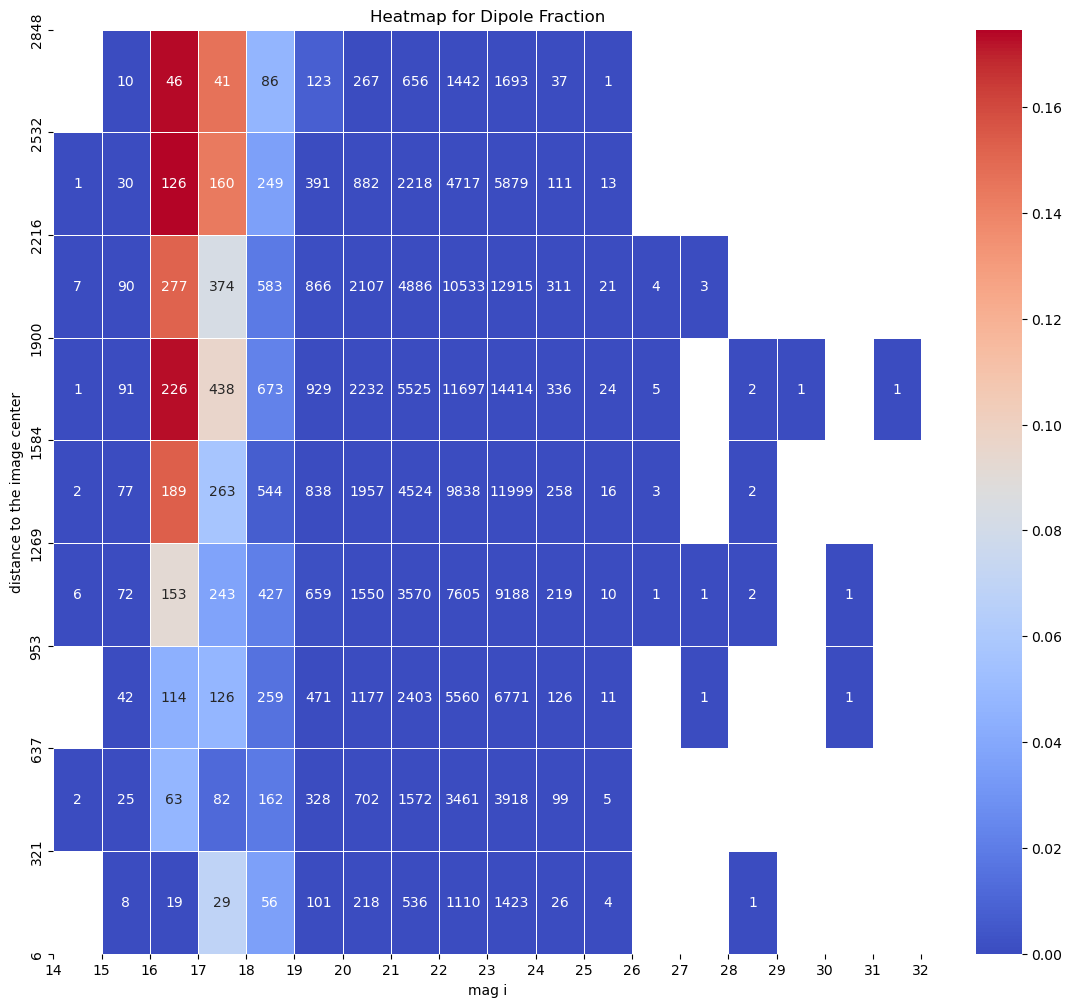

In [34]:
xbins = list(range(14, 33, 1))
ybins = list(np.linspace(6, 2848, 10).astype(int))

value = 'dipole_fraction'
title = 'Heatmap for Dipole Fraction'
heatmap = get_heatmap(distance_cut, xbins, ybins)
plot_heatmap(heatmap, xbins, ybins, value=value, title=title)
plt.savefig('heatmap_distance.png', dpi=200)

In [32]:
len(distance_cut[
    np.logical_and(
        np.logical_and(distance_cut.mag_i > 23, distance_cut.mag_i<24),
        np.logical_and(distance_cut.distance>637, distance_cut.distance<953))])

6771